In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 1.4 MB/s eta 0:01:30
   ---------------------------------------- 0.8/124.9 MB 1.0 MB/s eta 0:01:59
   ---------------------------------------- 0.8/124.9 MB 1.0 MB/s eta 0:01:59
   ---------------------------------------- 1.0/124.9 MB 986.7 kB/s eta 0:02:06
    --------------------------------------- 1.6/124.9 MB 1.2 MB/s eta 0:01:41
    --------------------------------------- 2.4/124.9 MB 1.5 MB/s eta 0:01:20
    --------------------------------------- 2.6/124.9 MB 1.6 MB/s eta 0:01:15
   - -------------------------------------- 3.1/124.9 MB 1.7 MB/s eta 0:01:12
   - -------------------------------------- 3.1/124.9 MB 1.7 MB/s eta 0:01:12
   - -------------------------------------- 3.1/124.9 MB 1.7 MB/s eta 0:01:12
   - 


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

df = pd.read_csv('Month_Value_1.csv')
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df.set_index('Period', inplace=True)
df = df.loc[:'2020-04-30']
df = df.asfreq('MS')

In [6]:
# Feature engineering: Create lagged features and seasonal indicators
def create_features(df, target_col='Sales_quantity', max_lag=12):
    df = df.copy()
    # Lagged features (past sales)
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
        
    df['month'] = df.index.month
    return df

df = create_features(df)

df = df.dropna()

test_size = 12
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

# Define features and target
features = [col for col in df.columns if col.startswith('lag_') or col == 'month']
X_train = train[features]
y_train = train['Sales_quantity']
X_test = test[features]
y_test = test['Sales_quantity']

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


XGBoost Performance:
Mean Absolute Percentage Error (MAPE): 8.81%


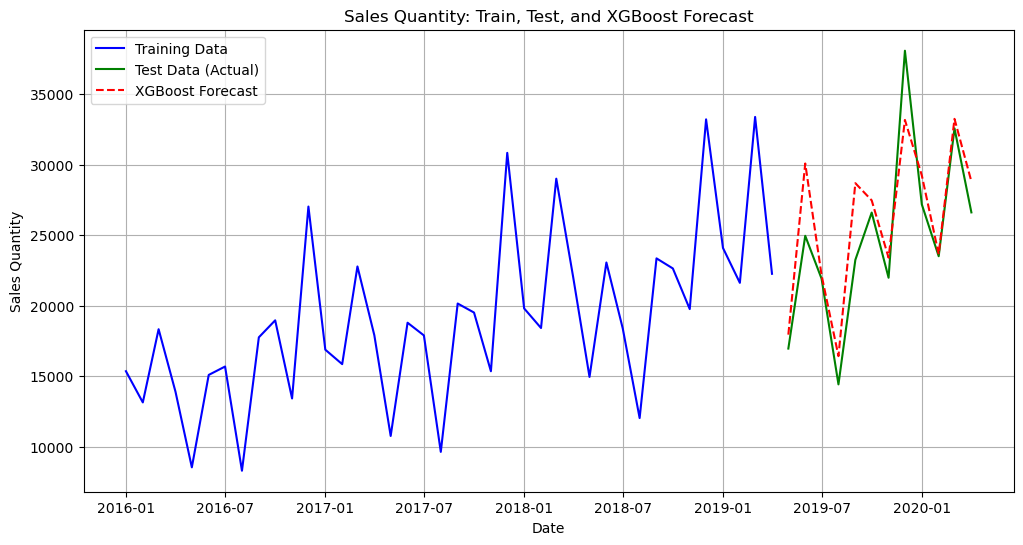

In [7]:
y_pred = model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nXGBoost Performance:")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales_quantity'], label='Training Data', color='blue')
plt.plot(test.index, y_test, label='Test Data (Actual)', color='green')
plt.plot(test.index, y_pred, label='XGBoost Forecast', color='red', linestyle='--')
plt.title('Sales Quantity: Train, Test, and XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.show()